In [86]:
from googleapiclient.discovery import build
import pandas as pd
import isodate
import re

In [ ]:
api_key = "" 
youtube = build("youtube", "v3", developerKey=api_key)

In [ ]:
api_key = "" 
youtube = build("youtube", "v3", developerKey=api_key)

In [89]:
all_video_ids = []
region = "US"
max_videos = 200
next_token = None

while len(all_video_ids) < max_videos:
    request = youtube.videos().list(
        part="id",
        chart="mostPopular",
        regionCode=region,
        maxResults=50,
        pageToken=next_token
    )
    response = request.execute()
    
    # Collect video IDs
    all_video_ids.extend([item['id'] for item in response['items']])
    
    next_token = response.get('nextPageToken')
    if not next_token:
        break

#Limit to max_videos in case we got extra
all_video_ids = all_video_ids[:max_videos]

print("Total video IDs fetched:", len(all_video_ids))


Total video IDs fetched: 200


In [90]:
all_video_ids_ng = []
region_ng = "NG"
max_videos = 200
next_token_ng = None

while len(all_video_ids_ng) < max_videos:
    request = youtube.videos().list(
        part="id",
        chart="mostPopular",
        regionCode=region_ng,
        maxResults=50,
        pageToken=next_token_ng
    )
    response = request.execute()
    
    # Collect video IDs
    all_video_ids_ng.extend([item['id'] for item in response['items']])
    
    next_token_ng = response.get('nextPageToken')
    if not next_token_ng:
        break

# Limit to max_videos in case we got extra
all_video_ids_ng = all_video_ids_ng[:max_videos]

print("Total NG video IDs fetched:", len(all_video_ids_ng))

Total NG video IDs fetched: 194


In [91]:
# YouTube API allows max 50 IDs per request
def chunks(lst, n):
    """Yield successive n-sized chunks from list"""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

data = []
import isodate

for batch in chunks(all_video_ids, 50):
    stats_response = youtube.videos().list(
        part="snippet,statistics,contentDetails",
        id=",".join(batch)
    ).execute()
    
    for video in stats_response['items']:
        snippet = video['snippet']
        stats = video.get('statistics', {})
        content = video.get('contentDetails', {})
        
        duration_seconds = None
        if 'duration' in content:
            duration_seconds = isodate.parse_duration(content['duration']).total_seconds()
        
        data.append({
            'videoId': video['id'],
            'title': snippet['title'],
            'channel': snippet['channelTitle'],
            'publishedAt': snippet['publishedAt'],
            'categoryId': snippet.get('categoryId'),
            'viewCount': int(stats.get('viewCount', 0)),
            'likeCount': int(stats.get('likeCount', 0)),
            'commentCount': int(stats.get('commentCount', 0)),
            'duration_seconds': duration_seconds
        })

In [92]:
data_ng = []

for batch in chunks(all_video_ids_ng, 50):  
    stats_response = youtube.videos().list(
        part="snippet,statistics,contentDetails",
        id=",".join(batch)
    ).execute()
    
    for video in stats_response['items']:
        snippet = video['snippet']
        stats = video.get('statistics', {})
        content = video.get('contentDetails', {})
        
        duration_seconds = None
        if 'duration' in content:
            duration_seconds = isodate.parse_duration(content['duration']).total_seconds()
        
        data_ng.append({
            'videoId': video['id'],
            'title': snippet['title'],
            'channel': snippet['channelTitle'],
            'publishedAt': snippet['publishedAt'],
            'categoryId': snippet.get('categoryId'),
            'viewCount': int(stats.get('viewCount', 0)),
            'likeCount': int(stats.get('likeCount', 0)),
            'commentCount': int(stats.get('commentCount', 0)),
            'duration_seconds': duration_seconds
        })

In [93]:
import pandas as pd

df = pd.DataFrame(data)

# Fetch category names dynamically
category_response = youtube.videoCategories().list(
    part="snippet",
    regionCode=region
).execute()

category_map = {item['id']: item['snippet']['title'] for item in category_response['items']}
df['categoryName'] = df['categoryId'].map(category_map)

# Reorder columns
df = df[['videoId', 'title', 'channel', 'publishedAt', 'categoryId', 
         'categoryName', 'viewCount', 'likeCount', 'commentCount', 'duration_seconds']]

In [94]:
print(df.head())

       videoId                                              title  \
0  9bS7oXSiYIM                    Reik - Noviembre Sin Ti (Letra)   
1  PssKpzB0Ah0     Stranger Things 5 | Official Trailer | Netflix   
2  mkUdveY0cFQ               WATCH OUT! Royal Hogs Evo flying by!   
3  zh0P40GfvFA          NLE The Great - KO (Official Music Video)   
4  CRAuK8T6Xis  Cyrene Character Trailer: "With You Once More"...   

             channel           publishedAt categoryId    categoryName  \
0          jostland.  2025-11-01T17:15:08Z         10           Music   
1            Netflix  2025-10-30T13:00:00Z         24   Entertainment   
2       Clash Royale  2025-11-01T15:01:24Z         20          Gaming   
3      NLE The Great  2025-10-30T23:01:28Z         22  People & Blogs   
4  Honkai: Star Rail  2025-11-02T04:00:21Z         20          Gaming   

   viewCount  likeCount  commentCount  duration_seconds  
0     864118       1108            17             203.0  
1   14498448     588360       

In [95]:
# Convert data_ng to a DataFrame
df_ng = pd.DataFrame(data_ng)

# Fetch category names dynamically for Nigeria
category_response_ng = youtube.videoCategories().list(
    part="snippet",
    regionCode="NG"
).execute()

# Create a map of categoryId to categoryName
category_map_ng = {item['id']: item['snippet']['title'] for item in category_response_ng['items']}

# Map category names to df_ng
df_ng['categoryName'] = df_ng['categoryId'].map(category_map_ng)

# Reorder columns
df_ng = df_ng[['videoId', 'title', 'channel', 'publishedAt', 'categoryId',
               'categoryName', 'viewCount', 'likeCount', 'commentCount', 'duration_seconds']]

print(df_ng.head())

       videoId                                              title  \
0  GodmYPfMaio                  Ayra Starr, Rema - Who’s Dat Girl   
1  PssKpzB0Ah0     Stranger Things 5 | Official Trailer | Netflix   
2  rKwwDoMs4HY  REAL MADRID 4 - 0 VALENCIA CF | RESUMEN LALIGA...   
3  dw8HOrauCdI                                     MONEY CONSTANT   
4  O84r72xZMlk  Patako Esu Yoruba Movie 2025 | Official Traile...   

                channel           publishedAt categoryId   categoryName  \
0         AyraStarrVEVO  2025-10-21T17:00:06Z         10          Music   
1               Netflix  2025-10-30T13:00:00Z         24  Entertainment   
2      LALIGA EA SPORTS  2025-11-01T22:23:19Z         17         Sports   
3  DJ Maphorisa - Topic  2025-10-23T22:01:24Z         10          Music   
4            Yorubaplus  2025-10-29T16:02:17Z         24  Entertainment   

   viewCount  likeCount  commentCount  duration_seconds  
0    7700699     206427         12743             214.0  
1   14498448     5

In [96]:
df.sort_values(by=['viewCount', 'likeCount'], ascending=False).head()

,videoId,title,channel,publishedAt,categoryId,categoryName,viewCount,likeCount,commentCount,duration_seconds
1,PssKpzB0Ah0,Stranger Things 5 | Official Trailer | Netflix,Netflix,2025-10-30T13:00:00Z,24,Entertainment,14498448,588360,30767,175.0
10,UJrghaPJ0RY,Scream 7 | Official Trailer (2026 Movie) – Nev...,Paramount Pictures,2025-10-30T13:00:02Z,1,Film & Animation,10112410,114498,11404,145.0
33,1Vg00spYj2g,100 Youtubers Vs World's Deadliest Player,MrBeast Gaming,2025-11-01T16:00:00Z,20,Gaming,5187051,173559,9939,1132.0
94,-0pnv8VN394,One Direction - Night Changes (Lyrics),Vibe Music,2025-10-30T17:57:50Z,10,Music,4228112,5667,162,227.0
127,tjii-glrXk4,T1 vs TES | 녹아웃 스테이지 Day6 4강 | 2025 월드 챔피언십,LCK,2025-11-02T10:11:05Z,20,Gaming,3954791,0,217,13701.0


In [97]:
df_ng.sort_values(by=['viewCount', 'likeCount'], ascending=False).head()

,videoId,title,channel,publishedAt,categoryId,categoryName,viewCount,likeCount,commentCount,duration_seconds
168,wlHwjkYpSr0,BABYMONSTER - ‘WE GO UP’ M/V,BABYMONSTER,2025-10-10T04:00:08Z,10,Music,128630302,1067361,84762,203.0
172,ko70cExuzZM,Taylor Swift - The Fate of Ophelia (Official M...,Taylor Swift,2025-10-05T23:00:06Z,10,Music,95647219,1712256,79900,239.0
186,2fyFx2u5fbU,izna 'Mamma Mia' MV,izna (이즈나),2025-09-30T09:00:06Z,24,Entertainment,35927799,132717,10273,228.0
180,hlULtigNNao,MEOVV(미야오) - ‘BURNING UP’ M/V,THEBLACKLABEL,2025-10-14T08:59:58Z,10,Music,34771974,0,15134,176.0
116,TvVtYaqCni8,LE SSERAFIM (르세라핌) 'SPAGHETTI (feat. j-hope of...,HYBE LABELS,2025-10-24T03:58:08Z,10,Music,27489561,985268,60591,199.0


In [98]:
import re

# Convert numeric columns
df['viewCount'] = pd.to_numeric(df['viewCount'], errors='coerce')
df['likeCount'] = pd.to_numeric(df['likeCount'], errors='coerce')
df['commentCount'] = pd.to_numeric(df['commentCount'], errors='coerce')

# Convert publishedAt to datetime
df['publishedAt'] = pd.to_datetime(df['publishedAt'])

In [99]:
# Like ratio, comment ratio, engagement rate
df['like_ratio'] = (df['likeCount'] / df['viewCount']).round(4)
df['comment_ratio'] = (df['commentCount'] / df['viewCount']).round(4)
df['engagement_rate'] = ((df['likeCount'] + df['commentCount']) / df['viewCount']).round(4)

In [100]:
# Title length
df['title_length'] = df['title'].apply(len)

# Title contains numbers
df['has_numbers'] = df['title'].apply(lambda x: bool(re.search(r'\d', x)))

# Title contains question mark
df['has_question_mark'] = df['title'].apply(lambda x: '?' in x)

In [101]:
df.sort_values(by=['viewCount', 'likeCount'], ascending=False).head()

,videoId,title,channel,publishedAt,categoryId,categoryName,viewCount,likeCount,commentCount,duration_seconds,like_ratio,comment_ratio,engagement_rate,title_length,has_numbers,has_question_mark
1,PssKpzB0Ah0,Stranger Things 5 | Official Trailer | Netflix,Netflix,2025-10-30 13:00:00+00:00,24,Entertainment,14498448,588360,30767,175.0,0.0406,0.0021,0.0427,46,True,False
10,UJrghaPJ0RY,Scream 7 | Official Trailer (2026 Movie) – Nev...,Paramount Pictures,2025-10-30 13:00:02+00:00,1,Film & Animation,10112410,114498,11404,145.0,0.0113,0.0011,0.0125,71,True,False
33,1Vg00spYj2g,100 Youtubers Vs World's Deadliest Player,MrBeast Gaming,2025-11-01 16:00:00+00:00,20,Gaming,5187051,173559,9939,1132.0,0.0335,0.0019,0.0354,41,True,False
94,-0pnv8VN394,One Direction - Night Changes (Lyrics),Vibe Music,2025-10-30 17:57:50+00:00,10,Music,4228112,5667,162,227.0,0.0013,0.0000,0.0014,38,False,False
127,tjii-glrXk4,T1 vs TES | 녹아웃 스테이지 Day6 4강 | 2025 월드 챔피언십,LCK,2025-11-02 10:11:05+00:00,20,Gaming,3954791,0,217,13701.0,0.0000,0.0001,0.0001,43,True,False


In [102]:
import re

# Convert numeric columns
df_ng['viewCount'] = pd.to_numeric(df_ng['viewCount'], errors='coerce')
df_ng['likeCount'] = pd.to_numeric(df_ng['likeCount'], errors='coerce')
df_ng['commentCount'] = pd.to_numeric(df_ng['commentCount'], errors='coerce')

# Convert publishedAt to datetime
df_ng['publishedAt'] = pd.to_datetime(df_ng['publishedAt'], errors='coerce')

In [103]:
# Like ratio, comment ratio, engagement rate
df_ng['like_ratio'] = (df_ng['likeCount'] / df_ng['viewCount']).round(4)
df_ng['comment_ratio'] = (df_ng['commentCount'] / df_ng['viewCount']).round(4)
df_ng['engagement_rate'] = ((df_ng['likeCount'] + df_ng['commentCount']) / df_ng['viewCount']).round(4)

# Title length
df_ng['title_length'] = df_ng['title'].apply(len)

# Title contains numbers
df_ng['has_numbers'] = df_ng['title'].apply(lambda x: bool(re.search(r'\d', x)))

# Title contains question mark
df_ng['has_question_mark'] = df_ng['title'].apply(lambda x: '?' in x)

In [104]:
df_ng.sort_values(by=['viewCount', 'likeCount'], ascending=False).head()

,videoId,title,channel,publishedAt,categoryId,categoryName,viewCount,likeCount,commentCount,duration_seconds,like_ratio,comment_ratio,engagement_rate,title_length,has_numbers,has_question_mark
168,wlHwjkYpSr0,BABYMONSTER - ‘WE GO UP’ M/V,BABYMONSTER,2025-10-10 04:00:08+00:00,10,Music,128630302,1067361,84762,203.0,0.0083,0.0007,0.0090,28,False,False
172,ko70cExuzZM,Taylor Swift - The Fate of Ophelia (Official M...,Taylor Swift,2025-10-05 23:00:06+00:00,10,Music,95647219,1712256,79900,239.0,0.0179,0.0008,0.0187,57,False,False
186,2fyFx2u5fbU,izna 'Mamma Mia' MV,izna (이즈나),2025-09-30 09:00:06+00:00,24,Entertainment,35927799,132717,10273,228.0,0.0037,0.0003,0.0040,19,False,False
180,hlULtigNNao,MEOVV(미야오) - ‘BURNING UP’ M/V,THEBLACKLABEL,2025-10-14 08:59:58+00:00,10,Music,34771974,0,15134,176.0,0.0000,0.0004,0.0004,29,False,False
116,TvVtYaqCni8,LE SSERAFIM (르세라핌) 'SPAGHETTI (feat. j-hope of...,HYBE LABELS,2025-10-24 03:58:08+00:00,10,Music,27489561,985268,60591,199.0,0.0358,0.0022,0.0380,64,False,False


In [186]:
# Group by categoryName
category_summary = df.groupby('categoryName').agg(
    total_views=('viewCount', 'sum'),
    avg_views=('viewCount', 'mean'),
    total_likes=('likeCount', 'sum'),
    avg_likes=('likeCount', 'mean'),
    total_comments=('commentCount', 'sum'),
    avg_comments=('commentCount', 'mean'),
    video_count=('videoId', 'count'),
    avg_engagement_rate=('engagement_rate', 'mean')
).sort_values('total_views', ascending=False)

# Round numeric columns for readability
category_summary = category_summary.round(2)

# Display the summary
print(category_summary)

                      total_views   avg_views  total_likes  avg_likes  \
categoryName                                                            
Gaming                   54467819   453898.49      1738312   14485.93   
Music                    22425967   560649.18       660141   16503.53   
Entertainment            20912745   995845.00       889014   42334.00   
Film & Animation         11676028  3892009.33       155379   51793.00   
People & Blogs            5662292   629143.56       214027   23780.78   
Sports                    4253607   850721.40        63806   12761.20   
Science & Technology       695473   695473.00        27039   27039.00   
Comedy                     658362   658362.00        34437   34437.00   

                      total_comments  avg_comments  video_count  \
categoryName                                                      
Gaming                        156288       1302.40          120   
Music                          38728        968.20           40   
E

In [106]:
# Group by categoryName
category_summary_ng = df_ng.groupby('categoryName').agg(
    total_views=('viewCount', 'sum'),
    avg_views=('viewCount', 'mean'),
    total_likes=('likeCount', 'sum'),
    avg_likes=('likeCount', 'mean'),
    total_comments=('commentCount', 'sum'),
    avg_comments=('commentCount', 'mean'),
    video_count=('videoId', 'count'),
    avg_engagement_rate=('engagement_rate', 'mean')
).sort_values('total_views', ascending=False)

# Round numeric columns for readability
category_summary_ng = category_summary_ng.round(2)

# Display the summary
print(category_summary_ng)

                  total_views   avg_views  total_likes  avg_likes  \
categoryName                                                        
Music               407258521  5902297.41      5978574   86646.00   
Entertainment        82165595  3286623.80      1110217   44408.68   
Gaming               66457922  1145826.24      1941899   33481.02   
Film & Animation     31293644  1955852.75       956889   59805.56   
Sports                9869555   986955.50       175094   17509.40   
People & Blogs        7530888   836765.33       213124   23680.44   
Howto & Style         5115930  2557965.00       140490   70245.00   
Pets & Animals         958924   958924.00         2696    2696.00   
News & Politics        162009   162009.00         9370    9370.00   
Comedy                  38444    19222.00          940     470.00   
Education                6804     6804.00          635     635.00   

                  total_comments  avg_comments  video_count  \
categoryName                           

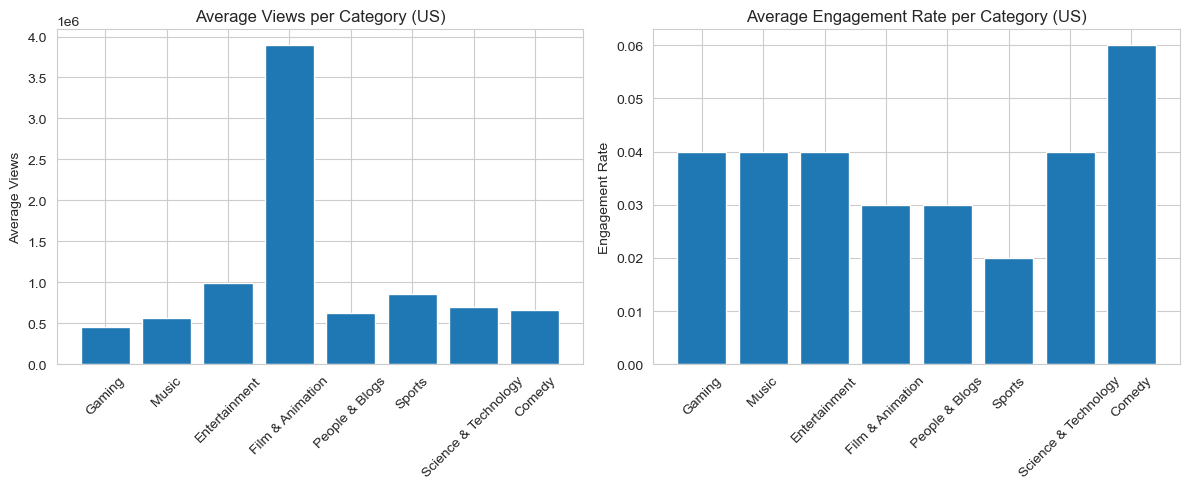

In [107]:
import matplotlib.pyplot as plt

# Set up figure
plt.figure(figsize=(12, 5))

# --- Chart 1: Average Views per Category ---
plt.subplot(1, 2, 1)
plt.bar(category_summary.index, category_summary['avg_views'])
plt.title('Average Views per Category (US)')
plt.ylabel('Average Views')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(category_summary.index, category_summary['avg_engagement_rate'])
plt.title('Average Engagement Rate per Category (US)')
plt.ylabel('Engagement Rate')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

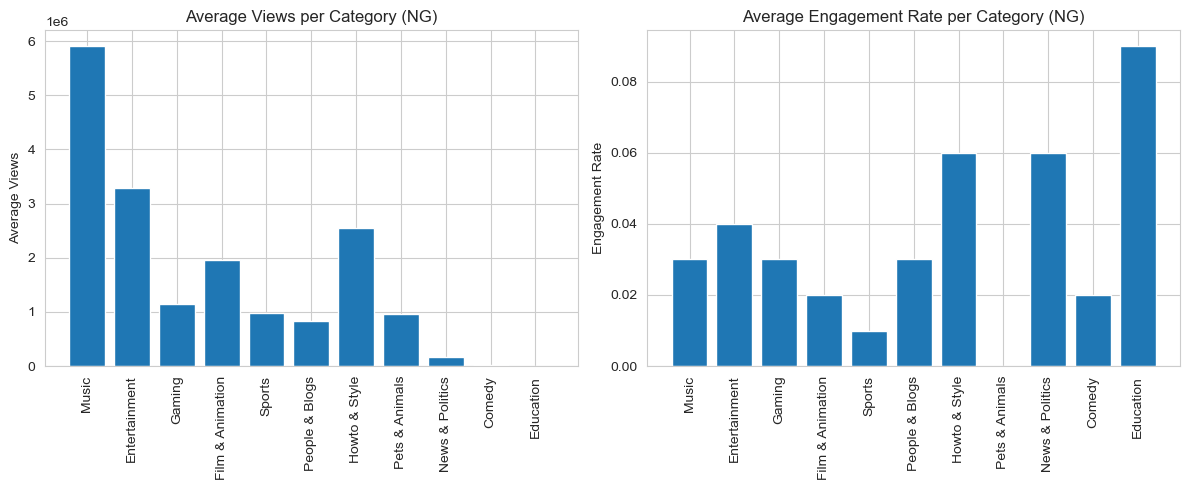

In [108]:
import matplotlib.pyplot as plt

# Set up figure
plt.figure(figsize=(12, 5))

# --- Chart 1: Average Views per Category ---
plt.subplot(1, 2, 1)
plt.bar(category_summary_ng.index, category_summary_ng['avg_views'])
plt.title('Average Views per Category (NG)')
plt.ylabel('Average Views')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
plt.bar(category_summary_ng.index, category_summary_ng['avg_engagement_rate'])
plt.title('Average Engagement Rate per Category (NG)')
plt.ylabel('Engagement Rate')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure your summary tables exist:
# category_summary_ng  (Nigeria) and category_summary  (US)

# Reset index so categoryName becomes a column
ng = category_summary_ng.reset_index().rename(columns={'categoryName': 'category'})
us = category_summary.reset_index().rename(columns={'categoryName': 'category'})

# Keep only the fields we need
ng_small = ng[['category', 'total_views', 'avg_engagement_rate']].copy().rename(
    columns={'total_views': 'total_views_NG', 'avg_engagement_rate': 'engagement_NG'}
)
us_small = us[['category', 'total_views', 'avg_engagement_rate']].copy().rename(
    columns={'total_views': 'total_views_US', 'avg_engagement_rate': 'engagement_US'}
)

# Merge so categories align (outer join to preserve categories unique to either region)
merged = pd.merge(ng_small, us_small, on='category', how='outer').fillna(0)

# Sort by combined total_views for nicer plotting
merged['total_combined'] = merged['total_views_NG'] + merged['total_views_US']
merged = merged.sort_values('total_combined', ascending=False).reset_index(drop=True)


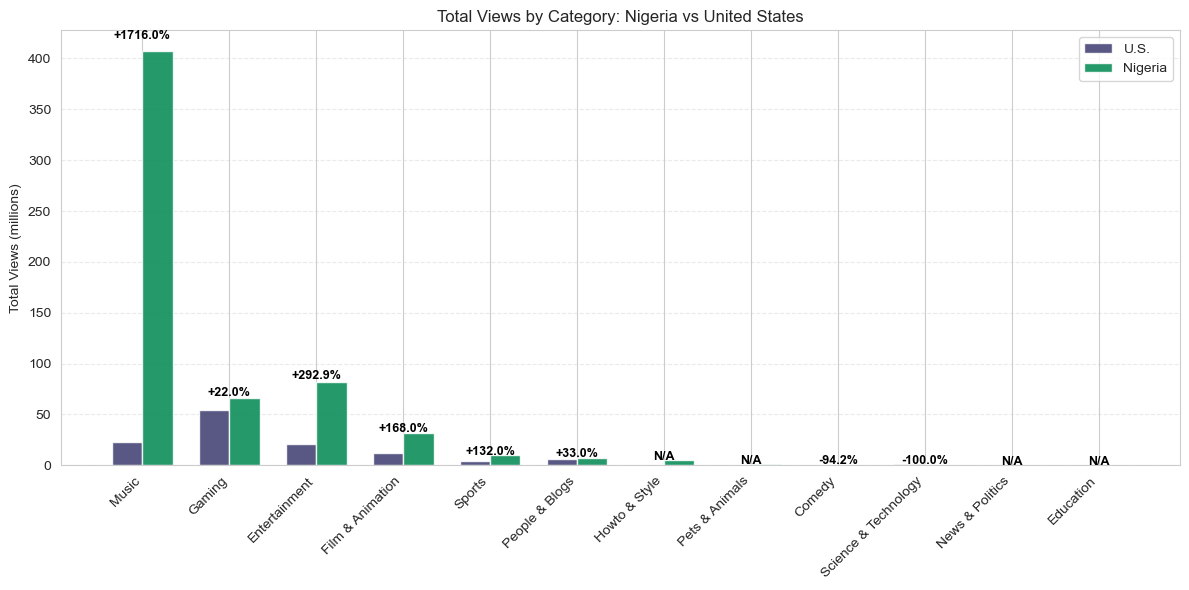

In [110]:
# Plot total views (display in millions for readability)
x = np.arange(len(merged))
width = 0.35

plt.figure(figsize=(12,6))
plt.bar(x - width/2, merged['total_views_US'] / 1e6, width, label='U.S.', color='#3C3B6E', alpha=0.85)
plt.bar(x + width/2, merged['total_views_NG'] / 1e6, width, label='Nigeria', color='#008751', alpha=0.85)

# Percent-diff annotations above each pair
for i in range(len(merged)):
    us_val = merged.loc[i, 'total_views_US']
    ng_val = merged.loc[i, 'total_views_NG']
    if us_val == 0:
        diff_text = 'N/A'
    else:
        diff = ((ng_val - us_val) / us_val) * 100
        diff_text = f"{diff:+.1f}%"
    top = max(us_val, ng_val) / 1e6
    plt.text(x[i], top + (top * 0.03) + 0.05, diff_text, ha='center', fontsize=9, color='black', fontweight='bold')

plt.xticks(x, merged['category'], rotation=45, ha='right')
plt.ylabel('Total Views (millions)')
plt.title('Total Views by Category: Nigeria vs United States')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

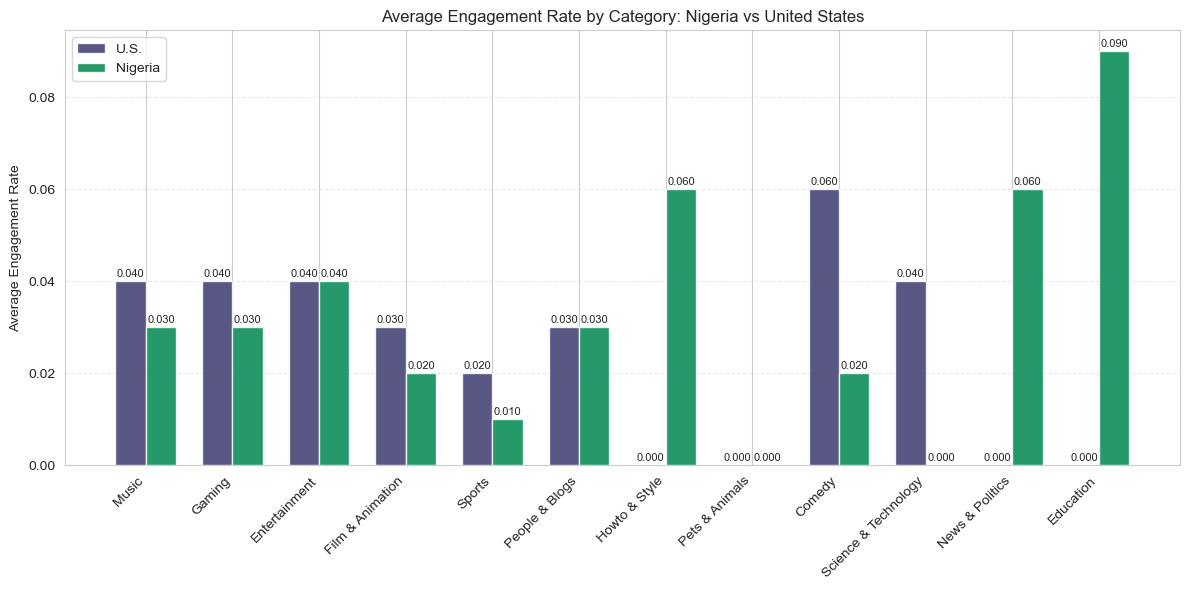

In [111]:
plt.figure(figsize=(12,6))
plt.bar(x - width/2, merged['engagement_US'], width, label='U.S.', color='#3C3B6E', alpha=0.85)
plt.bar(x + width/2, merged['engagement_NG'], width, label='Nigeria', color='#008751', alpha=0.85)

# Annotate engagement values (percent-style)
for i in range(len(merged)):
    plt.text(x[i] - width/2, merged.loc[i, 'engagement_US'] + 0.001, f"{merged.loc[i, 'engagement_US']:.3f}", ha='center', fontsize=8)
    plt.text(x[i] + width/2, merged.loc[i, 'engagement_NG'] + 0.001, f"{merged.loc[i, 'engagement_NG']:.3f}", ha='center', fontsize=8)

plt.xticks(x, merged['category'], rotation=45, ha='right')
plt.ylabel('Average Engagement Rate')
plt.title('Average Engagement Rate by Category: Nigeria vs United States')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [185]:
category_summary_ng

,total_views,avg_views,total_likes,avg_likes,total_comments,avg_comments,video_count,avg_engagement_rate
categoryName,,,,,,,,
Music,407259005,5902304.42,5978615,86646.59,343271,4974.94,69,0.03
Entertainment,82165853,3286634.12,1110231,44409.24,60619,2424.76,25,0.04
Gaming,66462797,1145910.29,1942001,33482.78,158304,2729.38,58,0.03
Film & Animation,31293904,1955869.00,956893,59805.81,59289,3705.56,16,0.02
Sports,9869839,986983.90,175109,17510.90,7725,772.50,10,0.01
People & Blogs,7539960,837773.33,213150,23683.33,33294,3699.33,9,0.03
Howto & Style,5115930,2557965.00,140495,70247.50,4840,2420.00,2,0.06
Pets & Animals,958924,958924.00,2696,2696.00,46,46.00,1,0.00
News & Politics,162009,162009.00,9370,9370.00,612,612.00,1,0.06


In [187]:
category_summary

,total_views,avg_views,total_likes,avg_likes,total_comments,avg_comments,video_count,avg_engagement_rate
categoryName,,,,,,,,
Gaming,54467819,453898.49,1738312,14485.93,156288,1302.40,120,0.04
Music,22425967,560649.18,660141,16503.53,38728,968.20,40,0.04
Entertainment,20912745,995845.00,889014,42334.00,56186,2675.52,21,0.04
Film & Animation,11676028,3892009.33,155379,51793.00,13583,4527.67,3,0.03
People & Blogs,5662292,629143.56,214027,23780.78,34327,3814.11,9,0.03
Sports,4253607,850721.40,63806,12761.20,2924,584.80,5,0.02
Science & Technology,695473,695473.00,27039,27039.00,2945,2945.00,1,0.04
Comedy,658362,658362.00,34437,34437.00,3093,3093.00,1,0.06


In [188]:
# Sort categories by avg_engagement_rate
engagement_sorted = category_summary.sort_values('avg_engagement_rate', ascending=False)
print(engagement_sorted[['avg_engagement_rate', 'total_views', 'video_count']])

                      avg_engagement_rate  total_views  video_count
categoryName                                                       
Comedy                               0.06       658362            1
Gaming                               0.04     54467819          120
Music                                0.04     22425967           40
Entertainment                        0.04     20912745           21
Science & Technology                 0.04       695473            1
Film & Animation                     0.03     11676028            3
People & Blogs                       0.03      5662292            9
Sports                               0.02      4253607            5


In [190]:
engagement_sorted_ng = category_summary_ng.sort_values('avg_engagement_rate', ascending=False)
print(engagement_sorted_ng[['avg_engagement_rate', 'total_views', 'video_count']])

                  avg_engagement_rate  total_views  video_count
categoryName                                                   
Education                        0.09         6804            1
Howto & Style                    0.06      5115930            2
News & Politics                  0.06       162009            1
Entertainment                    0.04     82165853           25
Music                            0.03    407259005           69
Gaming                           0.03     66462797           58
People & Blogs                   0.03      7539960            9
Film & Animation                 0.02     31293904           16
Comedy                           0.02        38444            2
Sports                           0.01      9869839           10
Pets & Animals                   0.00       958924            1


In [113]:
#duration summary
duration_summary = df.groupby('categoryName').agg(
    avg_duration_seconds=('duration_seconds', 'mean'),
    max_duration_seconds=('duration_seconds', 'max'),
    min_duration_seconds=('duration_seconds', 'min')
).round(2)

print(duration_summary)

                      avg_duration_seconds  max_duration_seconds  \
categoryName                                                       
Comedy                             1528.00                1528.0   
Entertainment                      2140.24               14539.0   
Film & Animation                    940.33                2028.0   
Gaming                             5846.38               41480.0   
Music                               509.65                8483.0   
People & Blogs                     2691.67               10134.0   
Science & Technology               1193.00                1193.0   
Sports                             8244.80               18501.0   

                      min_duration_seconds  
categoryName                                
Comedy                              1528.0  
Entertainment                         81.0  
Film & Animation                     145.0  
Gaming                                45.0  
Music                                 77.0  
Peop

In [189]:
duration_summary_ng = df_ng.groupby('categoryName').agg(
    avg_duration_seconds=('duration_seconds', 'mean'),
    max_duration_seconds=('duration_seconds', 'max'),
    min_duration_seconds=('duration_seconds', 'min')
).round(2)

print(duration_summary_ng)

                  avg_duration_seconds  max_duration_seconds  \
categoryName                                                   
Comedy                          122.50                 180.0   
Education                       441.00                 441.0   
Entertainment                  1084.84               18465.0   
Film & Animation                730.88                6551.0   
Gaming                         5156.72               23903.0   
Howto & Style                   322.00                 427.0   
Music                           275.94                1876.0   
News & Politics                1136.00                1136.0   
People & Blogs                 1372.56                6208.0   
Pets & Animals                  493.00                 493.0   
Sports                         5183.30               11250.0   

                  min_duration_seconds  
categoryName                            
Comedy                            65.0  
Education                        441.0  
Ent

C:\Users\personal\AppData\Local\Temp\ipykernel_14568\1927654813.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


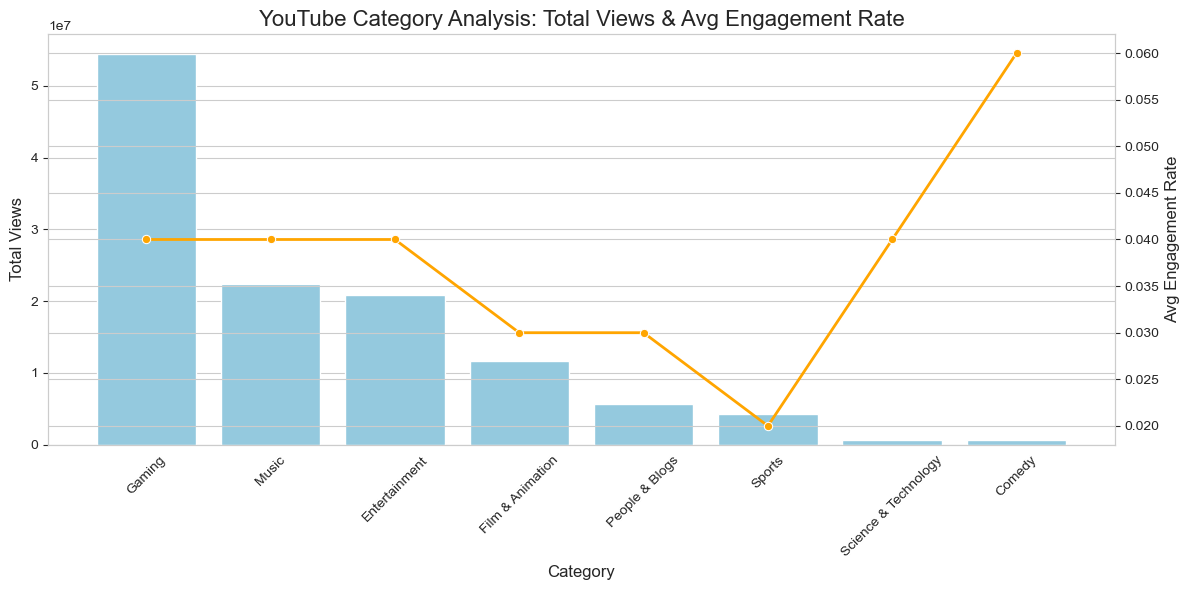

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reset index if categoryName is the index
df_plot = category_summary.reset_index()

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(12,6))

# Create primary axis for total views
ax = sns.barplot(
    data=df_plot,
    x='categoryName',
    y='total_views',
    color='skyblue'
)

# Create secondary axis for avg engagement rate
ax2 = ax.twinx()
sns.lineplot(
    data=df_plot,
    x='categoryName',
    y='avg_engagement_rate',
    color='orange',
    marker='o',
    linewidth=2,
    ax=ax2
)

# Titles and labels
ax.set_title("YouTube Category Analysis: Total Views & Avg Engagement Rate", fontsize=16)
ax.set_xlabel("Category", fontsize=12)
ax.set_ylabel("Total Views", fontsize=12)
ax2.set_ylabel("Avg Engagement Rate", fontsize=12)

# Rotate x-axis labels for readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

C:\Users\personal\AppData\Local\Temp\ipykernel_14568\3075852463.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


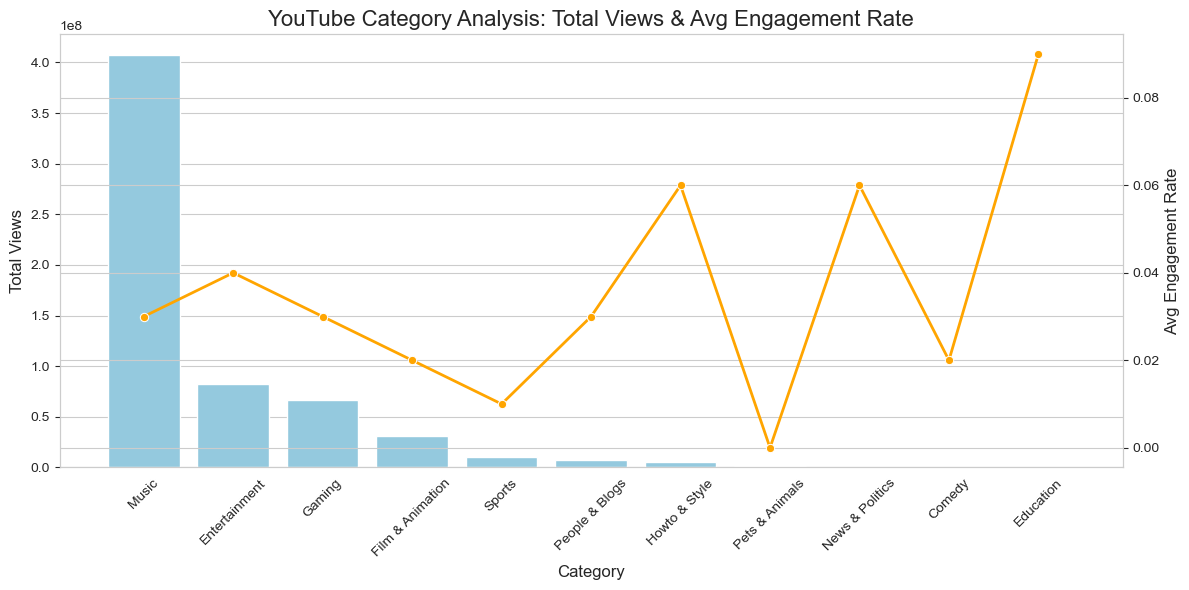

In [192]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reset index if categoryName is the index
df_ng_plot = category_summary_ng.reset_index()

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(12,6))

# Create primary axis for total views
ax = sns.barplot(
    data=df_ng_plot,
    x='categoryName',
    y='total_views',
    color='skyblue'
)

# Create secondary axis for avg engagement rate
ax2 = ax.twinx()
sns.lineplot(
    data=df_ng_plot,
    x='categoryName',
    y='avg_engagement_rate',
    color='orange',
    marker='o',
    linewidth=2,
    ax=ax2
)

# Titles and labels
ax.set_title("YouTube Category Analysis: Total Views & Avg Engagement Rate", fontsize=16)
ax.set_xlabel("Category", fontsize=12)
ax.set_ylabel("Total Views", fontsize=12)
ax2.set_ylabel("Avg Engagement Rate", fontsize=12)

# Rotate x-axis labels for readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

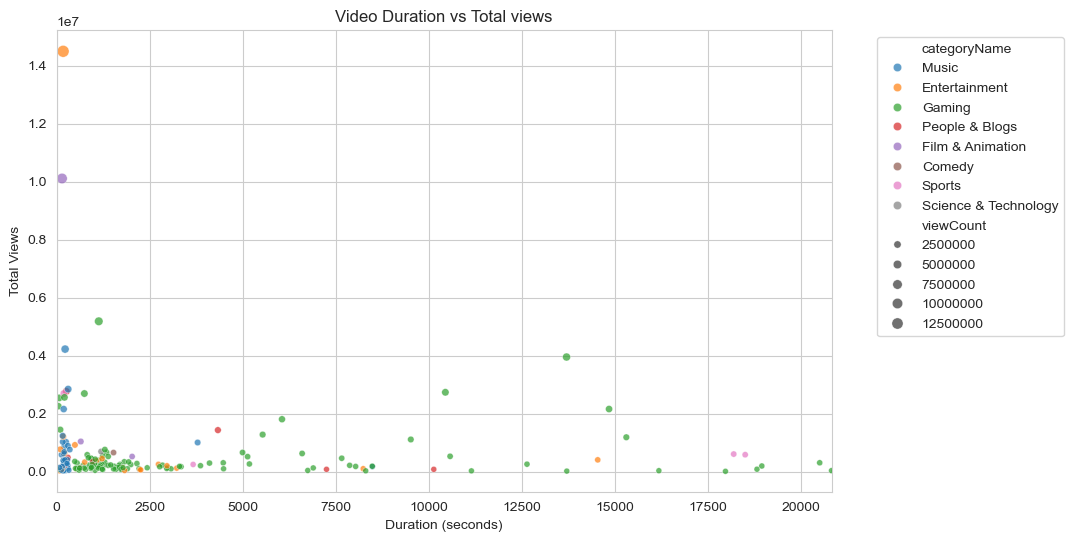

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure duration_seconds and engagement_rate are numeric
df['duration_seconds'] = pd.to_numeric(df['duration_seconds'], errors='coerce')
df['viewCount'] = pd.to_numeric(df['viewCount'], errors='coerce')

# Scatter plot of Duration vs Engagement Rate
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df,
    x='duration_seconds',
    y='viewCount',
    size='viewCount',      # Optional: size by views for context
    hue='categoryName',    # Color by category
    palette='tab10',
    alpha=0.7
)

plt.title('Video Duration vs Total views')
plt.xlabel('Duration (seconds)')
plt.ylabel('Total Views')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0, df['duration_seconds'].quantile(0.95))  # Optional: cut out extreme outliers
plt.show()

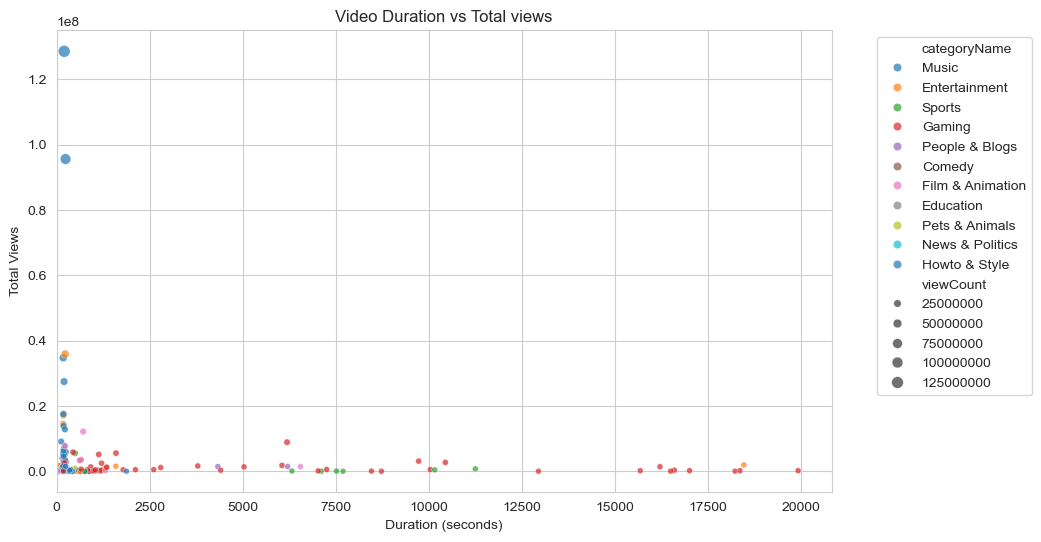

In [193]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of Duration vs Engagement Rate
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_ng,
    x='duration_seconds',
    y='viewCount',
    size='viewCount',      # Optional: size by views for context
    hue='categoryName',    # Color by category
    palette='tab10',
    alpha=0.7
)

plt.title('Video Duration vs Total views')
plt.xlabel('Duration (seconds)')
plt.ylabel('Total Views')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0, df['duration_seconds'].quantile(0.95))  # Optional: cut out extreme outliers
plt.show()

In [116]:
title_features = df.groupby('categoryName').agg(
    avg_title_length=('title_length', 'mean'),
    percent_with_numbers=('has_numbers', 'mean'),
    percent_with_question=('has_question_mark', 'mean')
).round(2)

print(title_features)

                      avg_title_length  percent_with_numbers  \
categoryName                                                   
Comedy                           32.00                  0.00   
Entertainment                    43.90                  0.24   
Film & Animation                 69.33                  1.00   
Gaming                           48.63                  0.34   
Music                            43.05                  0.15   
People & Blogs                   47.00                  0.33   
Science & Technology             39.00                  0.00   
Sports                           64.60                  0.80   

                      percent_with_question  
categoryName                                 
Comedy                                 0.00  
Entertainment                          0.00  
Film & Animation                       0.00  
Gaming                                 0.05  
Music                                  0.00  
People & Blogs                       

In [194]:
title_features_ng = df_ng.groupby('categoryName').agg(
    avg_title_length=('title_length', 'mean'),
    percent_with_numbers=('has_numbers', 'mean'),
    percent_with_question=('has_question_mark', 'mean')
).round(2)

print(title_features_ng)

                  avg_title_length  percent_with_numbers  \
categoryName                                               
Comedy                       79.00                  0.50   
Education                    39.00                  0.00   
Entertainment                57.40                  0.68   
Film & Animation             67.62                  0.75   
Gaming                       59.66                  0.60   
Howto & Style                87.00                  1.00   
Music                        28.65                  0.09   
News & Politics              94.00                  1.00   
People & Blogs               58.67                  0.56   
Pets & Animals               87.00                  0.00   
Sports                       73.60                  1.00   

                  percent_with_question  
categoryName                             
Comedy                             0.00  
Education                          0.00  
Entertainment                      0.04  
Film & An

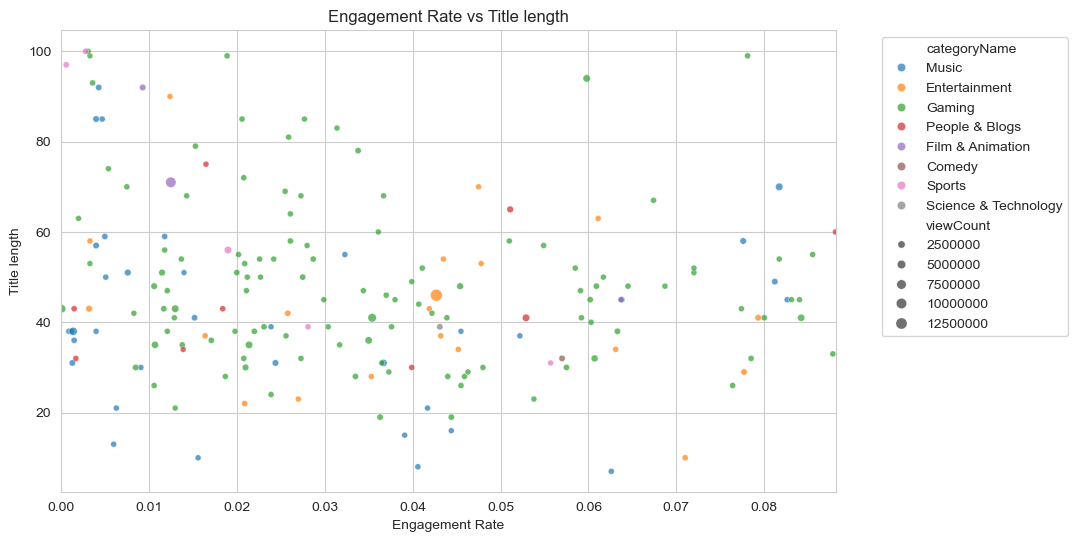

In [117]:
# Make sure duration_seconds and engagement_rate are numeric
df['engagement_rate'] = pd.to_numeric(df['engagement_rate'], errors='coerce')
df['title_length'] = pd.to_numeric(df['title_length'], errors='coerce')

# Scatter plot of Duration vs Engagement Rate
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df,
    x='engagement_rate',
    y='title_length',
    size='viewCount',      # Optional: size by views for context
    hue='categoryName',    # Color by category
    palette='tab10',
    alpha=0.7
)

plt.title('Engagement Rate vs Title length')
plt.xlabel('Engagement Rate')
plt.ylabel('Title length')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0, df['engagement_rate'].quantile(0.95))  # Optional: cut out extreme outliers
plt.show()

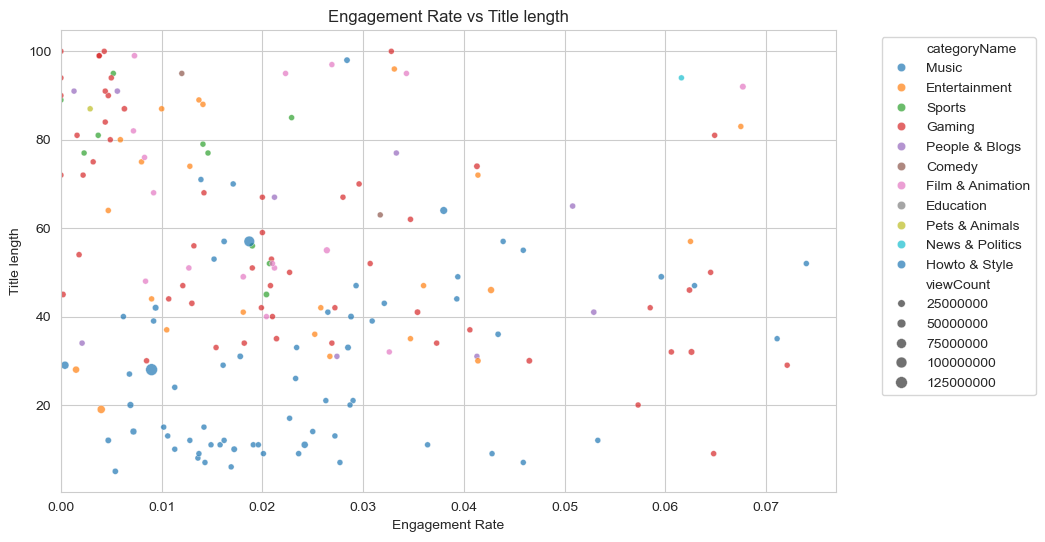

In [195]:
# Scatter plot of Duration vs Engagement Rate
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_ng,
    x='engagement_rate',
    y='title_length',
    size='viewCount',      # Optional: size by views for context
    hue='categoryName',    # Color by category
    palette='tab10',
    alpha=0.7
)

plt.title('Engagement Rate vs Title length')
plt.xlabel('Engagement Rate')
plt.ylabel('Title length')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0, df_ng['engagement_rate'].quantile(0.95))  # Optional: cut out extreme outliers
plt.show()

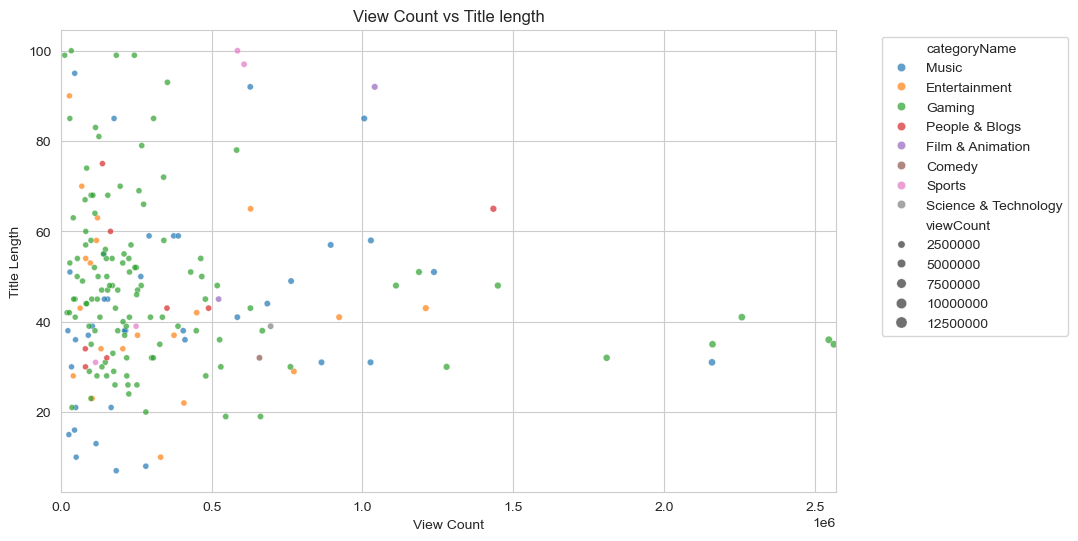

In [119]:
# Make sure duration_seconds and engagement_rate are numeric
df['viewCount'] = pd.to_numeric(df['viewCount'], errors='coerce')
df['title_length'] = pd.to_numeric(df['title_length'], errors='coerce')

# Scatter plot of Duration vs Engagement Rate
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df,
    x='viewCount',
    y='title_length',
    size='viewCount',      # Optional: size by views for context
    hue='categoryName',    # Color by category
    palette='tab10',
    alpha=0.7
)

plt.title('View Count vs Title length')
plt.xlabel('View Count')
plt.ylabel('Title Length')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0, df['viewCount'].quantile(0.95))  # Optional: cut out extreme outliers
plt.show()

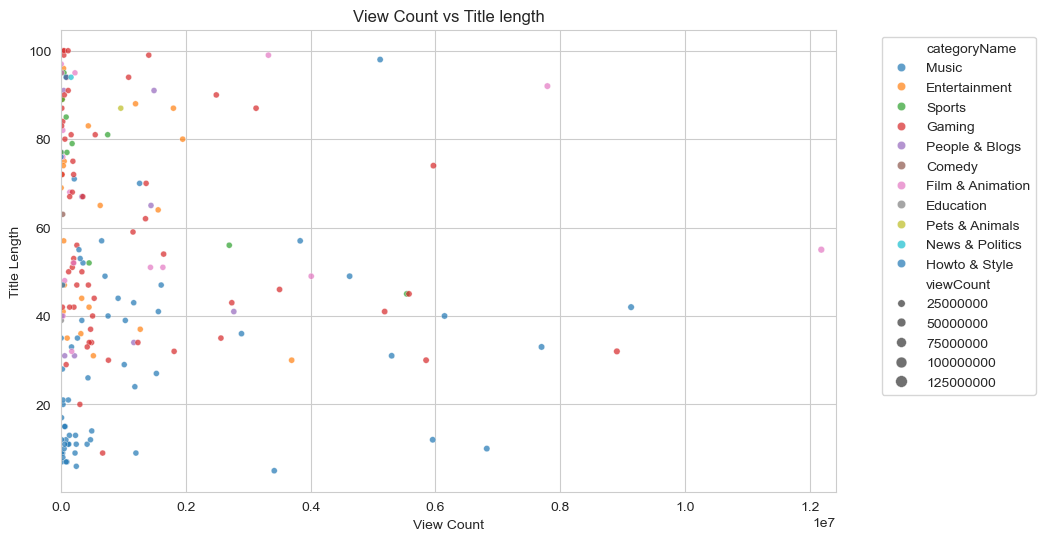

In [196]:
# Scatter plot of Duration vs Engagement Rate
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_ng,
    x='viewCount',
    y='title_length',
    size='viewCount',      # Optional: size by views for context
    hue='categoryName',    # Color by category
    palette='tab10',
    alpha=0.7
)

plt.title('View Count vs Title length')
plt.xlabel('View Count')
plt.ylabel('Title Length')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0, df_ng['viewCount'].quantile(0.95))  # Optional: cut out extreme outliers
plt.show()

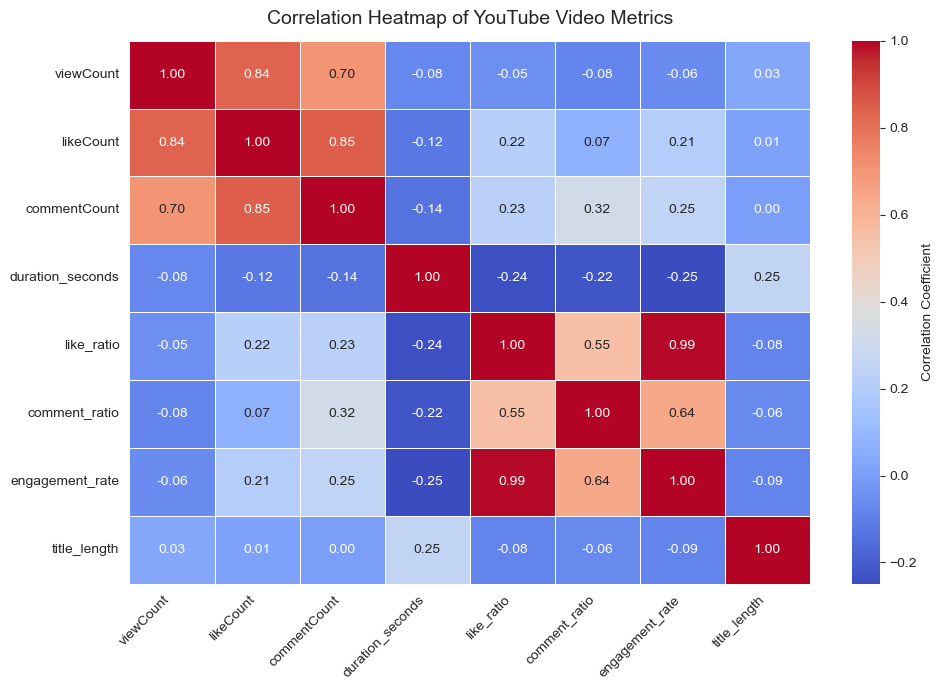

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include='number')

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 7))

# Create the heatmap
sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)

plt.title('Correlation Heatmap of YouTube Video Metrics', fontsize=14, pad=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

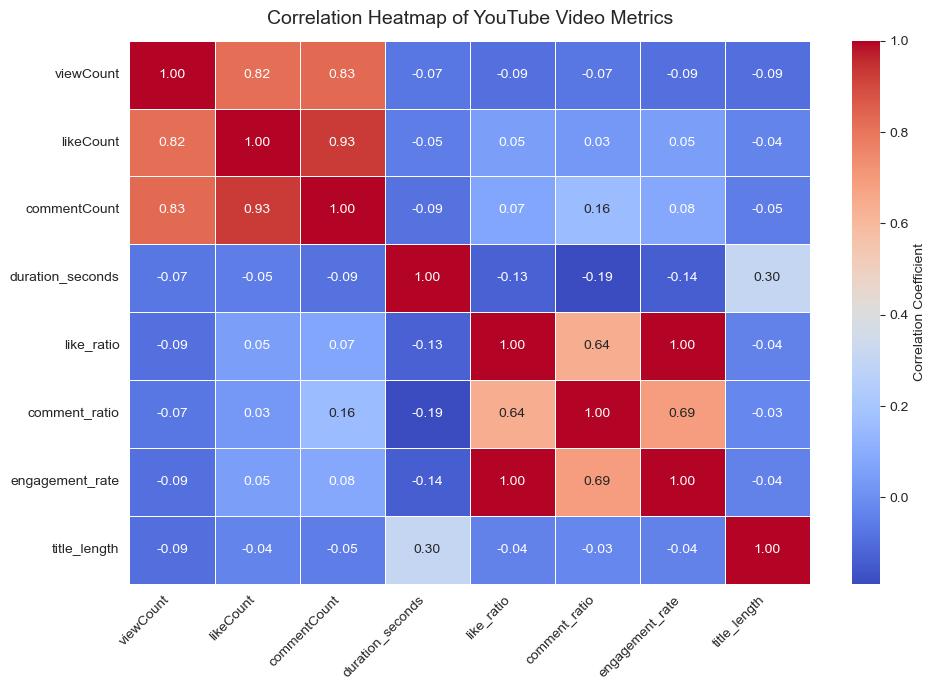

In [197]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric columns for correlation
numeric_df_ng = df_ng.select_dtypes(include='number')

# Compute correlation matrix
corr_matrix_ng = numeric_df_ng.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 7))

# Create the heatmap
sns.heatmap(
    corr_matrix_ng, 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)

plt.title('Correlation Heatmap of YouTube Video Metrics', fontsize=14, pad=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [198]:
# Group by categoryName and calculate relevant averages
category_summary = df.groupby('categoryName').agg({
    'viewCount': 'mean',
    'likeCount': 'mean',
    'commentCount': 'mean',
    'duration_seconds': 'mean',
    'engagement_rate': 'mean'
}).sort_values('engagement_rate', ascending=False)

# Round for neatness
category_summary = category_summary.sort_values('viewCount', ascending=False).round(2)

# Display top 5 categories by engagement rate
print("📊 Top 5 Categories by Engagement Rate:\n")
print(category_summary.head(5))

📊 Top 5 Categories by Engagement Rate:

                       viewCount  likeCount  commentCount  duration_seconds  \
categoryName                                                                  
Film & Animation      3892009.33    51793.0       4527.67            940.33   
Entertainment          995845.00    42334.0       2675.52           2140.24   
Sports                 850721.40    12761.2        584.80           8244.80   
Science & Technology   695473.00    27039.0       2945.00           1193.00   
Comedy                 658362.00    34437.0       3093.00           1528.00   

                      engagement_rate  
categoryName                           
Film & Animation                 0.03  
Entertainment                    0.04  
Sports                           0.02  
Science & Technology             0.04  
Comedy                           0.06  


In [199]:
# Group by categoryName and calculate relevant averages
category_summary_ng2 = df_ng.groupby('categoryName').agg({
    'viewCount': 'mean',
    'likeCount': 'mean',
    'commentCount': 'mean',
    'duration_seconds': 'mean',
    'engagement_rate': 'mean'
}).sort_values('engagement_rate', ascending=False)

# Round for neatness
category_summary_ng2 = category_summary_ng2.sort_values('viewCount', ascending=False).round(2)

# Display top 5 categories by engagement rate
print("📊 Top 5 Categories by Engagement Rate:\n")
print(category_summary_ng2.head(5))

📊 Top 5 Categories by Engagement Rate:

                   viewCount  likeCount  commentCount  duration_seconds  \
categoryName                                                              
Music             5902304.42   86646.59       4974.94            275.94   
Entertainment     3286634.12   44409.24       2424.76           1084.84   
Howto & Style     2557965.00   70247.50       2420.00            322.00   
Film & Animation  1955869.00   59805.81       3705.56            730.88   
Gaming            1145910.29   33482.78       2729.38           5156.72   

                  engagement_rate  
categoryName                       
Music                        0.03  
Entertainment                0.04  
Howto & Style                0.06  
Film & Animation             0.02  
Gaming                       0.03  


In [123]:
# Identify the top categories across other metrics
top_engagement = category_summary['engagement_rate'].idxmax()
top_views = category_summary['viewCount'].idxmax()
top_likes = category_summary['likeCount'].idxmax()
top_duration = category_summary['duration_seconds'].idxmax()

print("\n🏆 Key Insights:")
print(f"• Highest Engagement Rate: {top_engagement}")
print(f"• Highest Average Views: {top_views}")
print(f"• Highest Average Likes: {top_likes}")
print(f"• Longest Average Duration: {top_duration}")


🏆 Key Insights:
• Highest Engagement Rate: Comedy
• Highest Average Views: Film & Animation
• Highest Average Likes: Film & Animation
• Longest Average Duration: Sports


In [201]:
# Identify the top categories across other metrics
top_engagement_ng = category_summary_ng2['engagement_rate'].idxmax()
top_views_ng = category_summary_ng2['viewCount'].idxmax()
top_likes_ng = category_summary_ng2['likeCount'].idxmax()
top_duration_ng = category_summary_ng2['duration_seconds'].idxmax()

print("\n🏆 Key Insights:")
print(f"• Highest Engagement Rate: {top_engagement_ng}")
print(f"• Highest Average Views: {top_views_ng}")
print(f"• Highest Average Likes: {top_likes_ng}")
print(f"• Longest Average Duration: {top_duration_ng}")


🏆 Key Insights:
• Highest Engagement Rate: Education
• Highest Average Views: Music
• Highest Average Likes: Music
• Longest Average Duration: Sports


In [126]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Select features and target
X = df[['duration_seconds', 'title_length', 'has_numbers', 'has_question_mark', 'categoryName']]
y = df['viewCount']

# One-hot encode categoryName
X = pd.get_dummies(X, columns=['categoryName'], drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Random Forest
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("🔍 Random Forest Model Performance (Predicting ViewCount)")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:,.0f}")
print(f"Root Mean Squared Error: {rmse:,.0f}")

# Feature importance
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n📊 Feature Importance (Random Forest)")
print(importances)

🔍 Random Forest Model Performance (Predicting ViewCount)
R² Score: -0.9486
Mean Absolute Error: 474,046
Root Mean Squared Error: 743,267

📊 Feature Importance (Random Forest)
                              Feature  Importance
0                    duration_seconds    0.538881
1                        title_length    0.175299
5       categoryName_Film & Animation    0.146630
2                         has_numbers    0.054981
4          categoryName_Entertainment    0.027913
6                 categoryName_Gaming    0.023960
7                  categoryName_Music    0.014073
10                categoryName_Sports    0.009534
8         categoryName_People & Blogs    0.007620
3                   has_question_mark    0.000735
9   categoryName_Science & Technology    0.000374


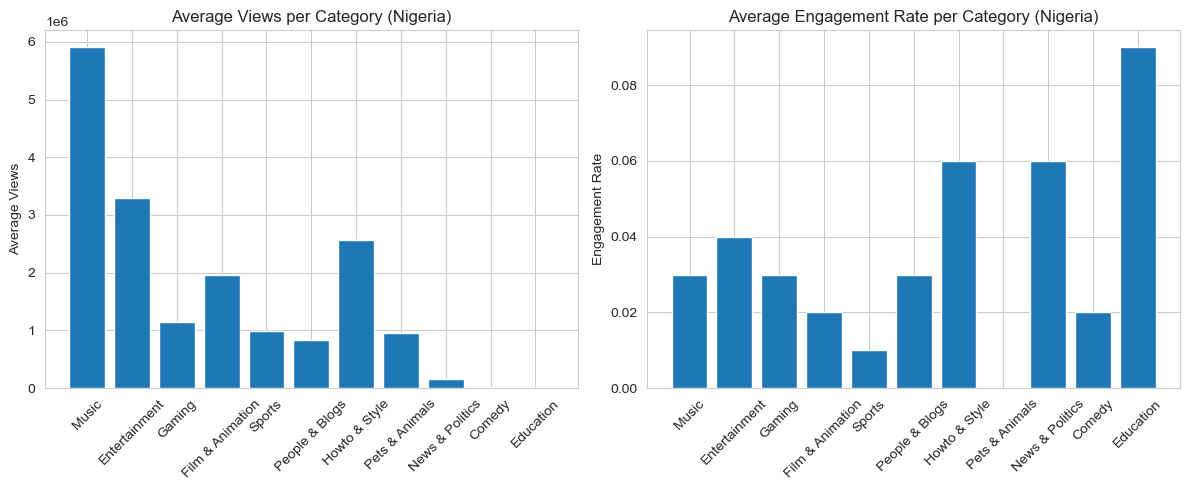

In [140]:
import matplotlib.pyplot as plt

# Set up figure
plt.figure(figsize=(12, 5))

# --- Chart 1: Average Views per Category ---
plt.subplot(1, 2, 1)
plt.bar(category_summary_ng.index, category_summary_ng['avg_views'])
plt.title('Average Views per Category (Nigeria)')
plt.ylabel('Average Views')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(category_summary_ng.index, category_summary_ng['avg_engagement_rate'])
plt.title('Average Engagement Rate per Category (Nigeria)')
plt.ylabel('Engagement Rate')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

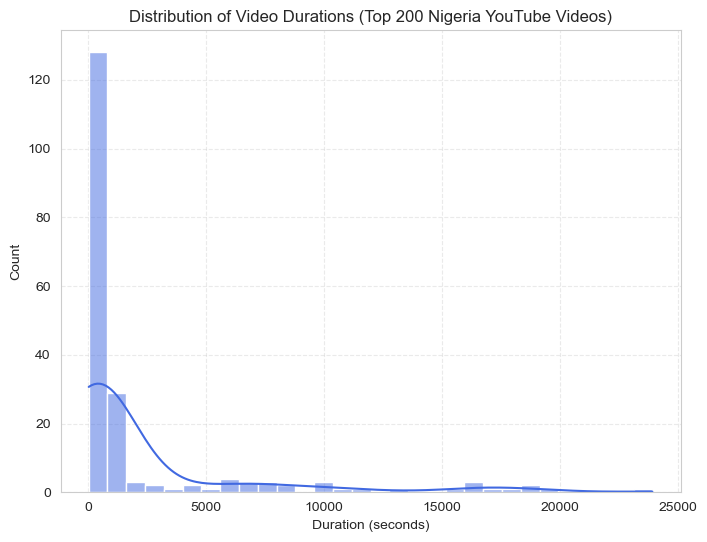

In [150]:
plt.figure(figsize=(8,6))
sns.histplot(df_ng['duration_seconds'], bins=30, color='royalblue', kde=True)
plt.title('Distribution of Video Durations (Top 200 Nigeria YouTube Videos)')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

categoryName
Sports                  8244.800000
Gaming                  5846.383333
People & Blogs          2691.666667
Entertainment           2140.238095
Comedy                  1528.000000
Science & Technology    1193.000000
Film & Animation         940.333333
Music                    509.650000
Name: duration_seconds, dtype: float64


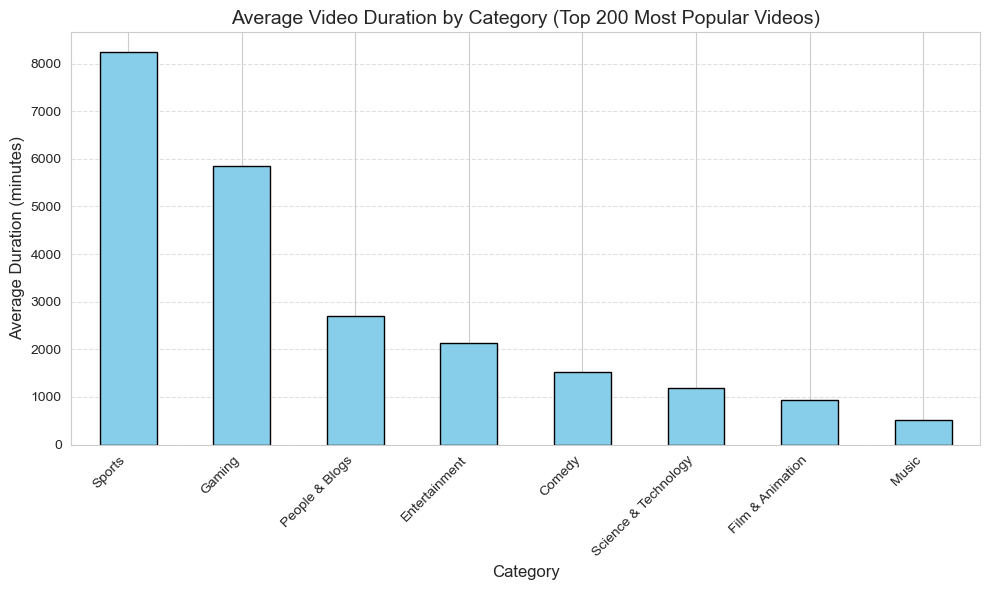

In [151]:
import matplotlib.pyplot as plt

# Group by category and calculate average duration (in minutes)
avg_duration_by_category = df.groupby('categoryName')['duration_seconds'].mean().sort_values(ascending=False)
print(avg_duration_by_category)
# Plot
plt.figure(figsize=(10,6))
avg_duration_by_category.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Average Video Duration by Category (Top 200 Most Popular Videos)', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Average Duration (minutes)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

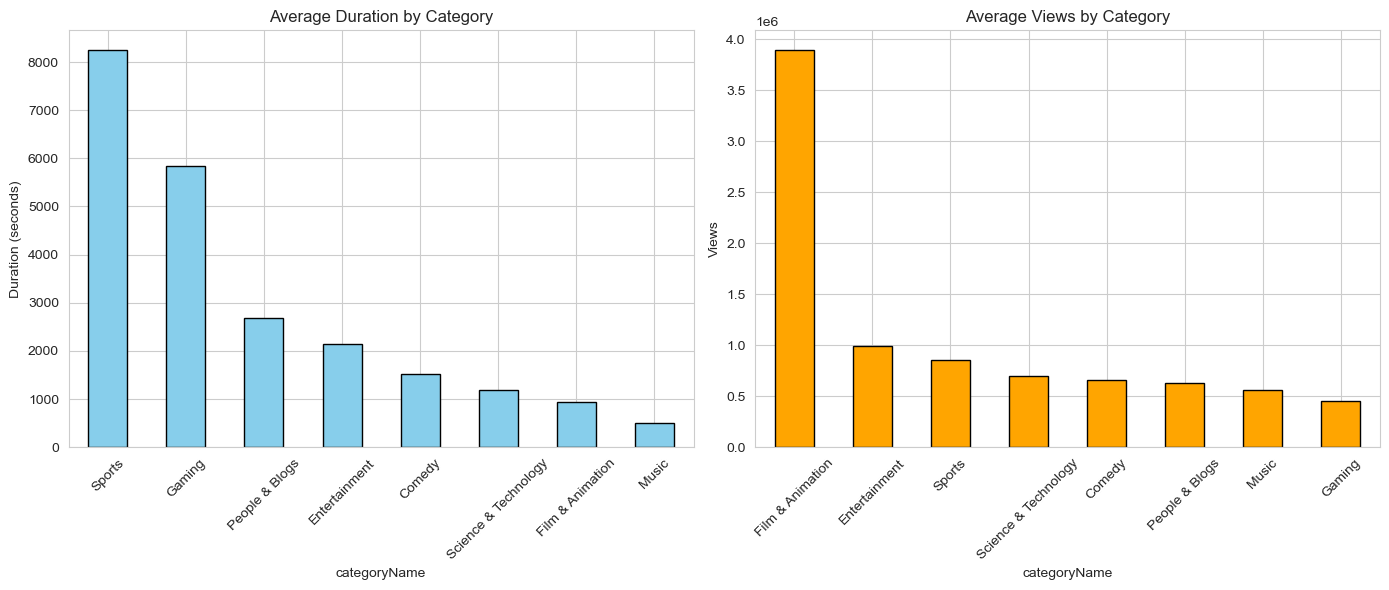

In [153]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Avg duration bar chart
df.groupby('categoryName')['duration_seconds'].mean().sort_values(ascending=False).plot(
    kind='bar', ax=axes[0], color='skyblue', edgecolor='black'
)
axes[0].set_title('Average Duration by Category')
axes[0].set_ylabel('Duration (seconds)')
axes[0].tick_params(axis='x', rotation=45)

# Avg views bar chart
df.groupby('categoryName')['viewCount'].mean().sort_values(ascending=False).plot(
    kind='bar', ax=axes[1], color='orange', edgecolor='black'
)
axes[1].set_title('Average Views by Category')
axes[1].set_ylabel('Views')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [154]:
# Assuming df_us and df_ng are your DataFrames
common_channels = set(df['channel']).intersection(set(df_ng['channel']))
unique_us = set(df['channel']) - set(df_ng['channel'])
unique_ng = set(df_ng['channel']) - set(df['channel'])

print("Number of common channels:", len(common_channels))
print("Unique to US:", unique_us)
print("Unique to NG:", unique_ng)

Number of common channels: 20
Unique to US: {'Sebbyastian', 'RICHLEV', 'RDCWorldGaming', 'VanossGaming', 'KevinRoldanOfficial', 'Socksfor2', 'CrowPoint', 'Maximilian Dood', 'BigPlayNate', 'Brettski', 'CaseOh', 'Skull Plays', 'Alaska Violet', 'Bluff', 'Clash Royale Esports', 'Grxnt', 'jacksepticeye', 'BachaBlox', 'Michael Knowles', 'Timeless Music', 'AromaKarsens - Topic', 'Sir Marcus', 'Comrad3s', 'FireFly', 'Doggie', 'EliSportsTv', 'Seanie Dew', 'Tyler, The Creator - Topic', 'Sxzxr', 'Mi Trocona Lyrics', 'JT Music', 'Lucky Chamu', 'shroud', 'Lyanno', 'EveryDay FN', 'PrestonPlayz', 'PliesWorld', 'Stimpee', 'KendoKaponiVEVO', 'The Offspring', 'Nathan Dawe', 'Dead Meat', 'Dreyci', 'Doni Bobes', 'SolidPlayzYT', 'REY DEPORTIVO', 'Thinknoodles', 'Kubz Scouts', 'Paramount Pictures', 'Crixara', 'Black Gryph0n', 'Brandon302', 'DiazBiffle', 'Ken', 'Aztecross', 'Ghoulz Gaming', 'AyeYahZee', 'NagBlox', 'DORA BLACK', 'Austin John Plays', 'Aphmau', '7clouds Rock', 'Valkyrae', 'Prófugos de Nuevo Leó

In [160]:
from collections import Counter

# Drop missing clean_title values just for safety
combined_df = combined_df.dropna(subset=['clean_title'])

# Ensure titles are lists of words
combined_df['clean_title'] = combined_df['clean_title'].apply(lambda x: x if isinstance(x, list) else str(x).split())

# Count words for each region
nigeria_words = Counter(
    [word for title in combined_df[combined_df['region'] == 'Nigeria']['clean_title'] for word in title]
)

us_words = Counter(
    [word for title in combined_df[combined_df['region'] == 'United States']['clean_title'] for word in title]
)

# Get top 20 keywords
nigeria_top = nigeria_words.most_common(20)
us_top = us_words.most_common(20)

nigeria_top, us_top

([],
 [('new', 21),
  ('official', 19),
  ('video', 17),
  ('minecraft', 13),
  ('game', 13),
  ('brainrot', 12),
  ('live', 12),
  ('music', 11),
  ('vs', 11),
  ('update', 11),
  ('steal', 11),
  ('trailer', 10),
  ('fortnite', 9),
  ('simpsons', 8),
  ('halloween', 7),
  ('brainrots', 7),
  ('world', 7),
  ('x', 6),
  ('day', 6),
  ('nights', 6)])

In [161]:
combined_df['region'].value_counts()

region
United States    200
Name: count, dtype: int64

In [162]:
df['region'] = 'United States'
df_ng['region'] = 'Nigeria'

combined_df = pd.concat([df, df_ng], ignore_index=True)

In [163]:
combined_df['region'].value_counts()

region
United States    200
Nigeria          194
Name: count, dtype: int64

In [164]:
combined_df[combined_df['region'] == 'Nigeria']['clean_title'].head(5)

200    NaN
201    NaN
202    NaN
203    NaN
204    NaN
Name: clean_title, dtype: object

In [165]:
import re

def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # remove punctuation
        words = text.split()
        return words
    else:
        return []

# Apply cleaning function to both datasets
df['clean_title'] = df['title'].apply(clean_text)
df_ng['clean_title'] = df_ng['title'].apply(clean_text)

In [166]:
df['region'] = 'United States'
df_ng['region'] = 'Nigeria'

combined_df = pd.concat([df, df_ng], ignore_index=True)

In [167]:
combined_df['region'].value_counts()

region
United States    200
Nigeria          194
Name: count, dtype: int64

In [168]:
combined_df[combined_df['region'] == 'Nigeria']['clean_title'].head(5)

200                 [ayra, starr, rema, whos, dat, girl]
201    [stranger, things, 5, official, trailer, netflix]
202    [real, madrid, 4, 0, valencia, cf, resumen, la...
203                                    [money, constant]
204    [patako, esu, yoruba, movie, 2025, official, t...
Name: clean_title, dtype: object

In [169]:
from collections import Counter

# Get top keywords for each region
nigeria_words = Counter([word for title in combined_df[combined_df['region']=='Nigeria']['clean_title'] for word in title])
us_words = Counter([word for title in combined_df[combined_df['region']=='United States']['clean_title'] for word in title])

# Get top 20
top_ng = nigeria_words.most_common(20)
top_us = us_words.most_common(20)

print("Top 20 Nigeria Keywords:\n", top_ng)
print("\nTop 20 U.S. Keywords:\n", top_us)


Top 20 Nigeria Keywords:
 [('official', 44), ('video', 29), ('2025', 27), ('trailer', 26), ('live', 26), ('vs', 26), ('in', 23), ('the', 21), ('i', 16), ('simulation', 15), ('music', 15), ('new', 14), ('a', 14), ('of', 13), ('real', 12), ('match', 12), ('madrid', 11), ('2', 11), ('efootball', 11), ('movie', 9)]

Top 20 U.S. Keywords:
 [('the', 50), ('in', 32), ('a', 27), ('i', 25), ('new', 21), ('official', 19), ('video', 17), ('to', 15), ('minecraft', 13), ('of', 13), ('game', 13), ('brainrot', 12), ('live', 12), ('music', 11), ('vs', 11), ('my', 11), ('steal', 11), ('trailer', 10), ('update', 10), ('is', 10)]


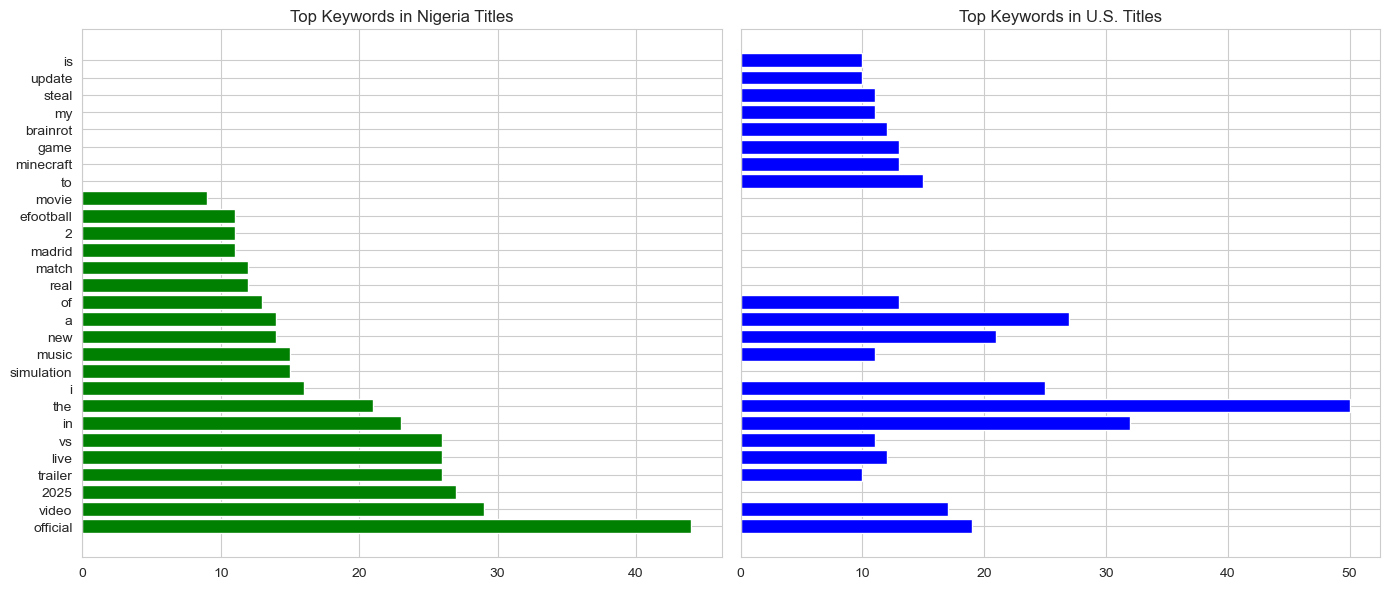

In [170]:
import matplotlib.pyplot as plt

# Convert to DataFrame
import pandas as pd
ng_df = pd.DataFrame(top_ng, columns=['word', 'count'])
us_df = pd.DataFrame(top_us, columns=['word', 'count'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axes[0].barh(ng_df['word'], ng_df['count'], color='green')
axes[0].set_title('Top Keywords in Nigeria Titles')
axes[0].invert_yaxis()

axes[1].barh(us_df['word'], us_df['count'], color='blue')
axes[1].set_title('Top Keywords in U.S. Titles')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()